In [40]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from reservoirpy.nodes import Reservoir, Ridge, Input

In [4]:
loaded_dataset = np.load("./out/all_features.npz")

X_dataset = loaded_dataset["X_dataset"]
Y_dataset = loaded_dataset["Y_dataset"]

print("X_dataset: ", X_dataset.shape)
print("Y_dataset: ", Y_dataset.shape)

X_dataset:  (3748, 1814, 3)
Y_dataset:  (3748,)


In [5]:
real_videos = X_dataset[Y_dataset[0] == 0]  # Videos with target 0
fake_videos = X_dataset[Y_dataset[0] == 1]  # Videos with target 1

# Calculate the mean EAR and Δ EAR for real and fake videos
mean_ear_real = np.mean(real_videos[:, :, 0], axis=0)  # Assuming EAR is feature 0
mean_delta_ear_real = np.mean(real_videos[:, :, 1], axis=0)  # Assuming Δ EAR is feature 1

mean_ear_fake = np.mean(fake_videos[:, :, 0], axis=0)

mean_delta_ear_fake = np.mean(fake_videos[:, :, 1], axis=0)

/Users/mughalfrazk/Study/SHU/Dissertation/code/deepfake-detection-using-esn/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mughalfrazk/Study/SHU/Dissertation/code/deepfake-detection-using-esn/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [6]:
print(X_dataset[0])
ear_data = X_dataset[:, :, 0]
print(ear_data[0])
ear_data = np.mean(ear_data, axis=1)
print(ear_data)

[[ 0.30268602  0.          0.        ]
 [ 0.28519616 -0.01748986  1.        ]
 [ 0.29701759  0.01182143  0.        ]
 ...
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[0.30268602 0.28519616 0.29701759 ... 0.         0.         0.        ]
[0.05520246 0.08906734 0.05365201 ... 0.04342458 0.25615751 0.04758027]


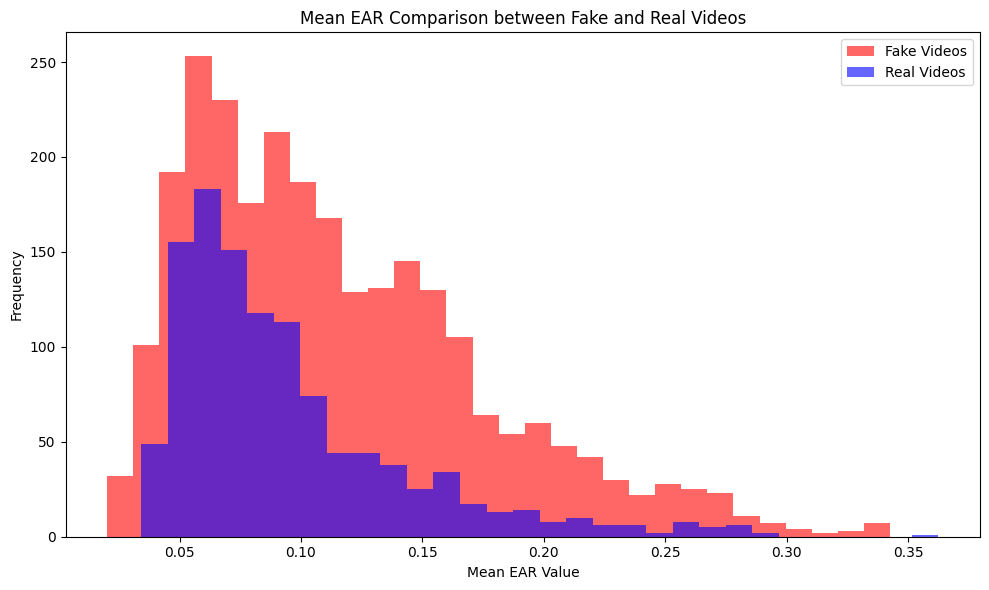

In [7]:
# Extract just the EAR feature (first feature in each frame)
ear_data = X_dataset[:, :, 0]
mean_ear = np.mean(ear_data, axis=1) 

# Split the data into fake and real videos based on the labels
mean_fake_ear = mean_ear[Y_dataset == 0]  # Mean EAR for fake videos
mean_real_ear = mean_ear[Y_dataset == 1]  # Mean EAR for real videos

# Plot the mean EAR values for fake and real videos
plt.figure(figsize=(10, 6))

# Plot the mean EAR for fake videos
plt.hist(mean_fake_ear, bins=30, alpha=0.6, label='Fake Videos', color='red')

# Plot the mean EAR for real videos
plt.hist(mean_real_ear, bins=30, alpha=0.6, label='Real Videos', color='blue')

# Add title and labels
plt.title('Mean EAR Comparison between Fake and Real Videos')
plt.xlabel('Mean EAR Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


/var/folders/7t/tn7d7_7x0294gvz7svhdqz480000gn/T/ipykernel_33593/872417236.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mean_fake_ear, mean_real_ear],


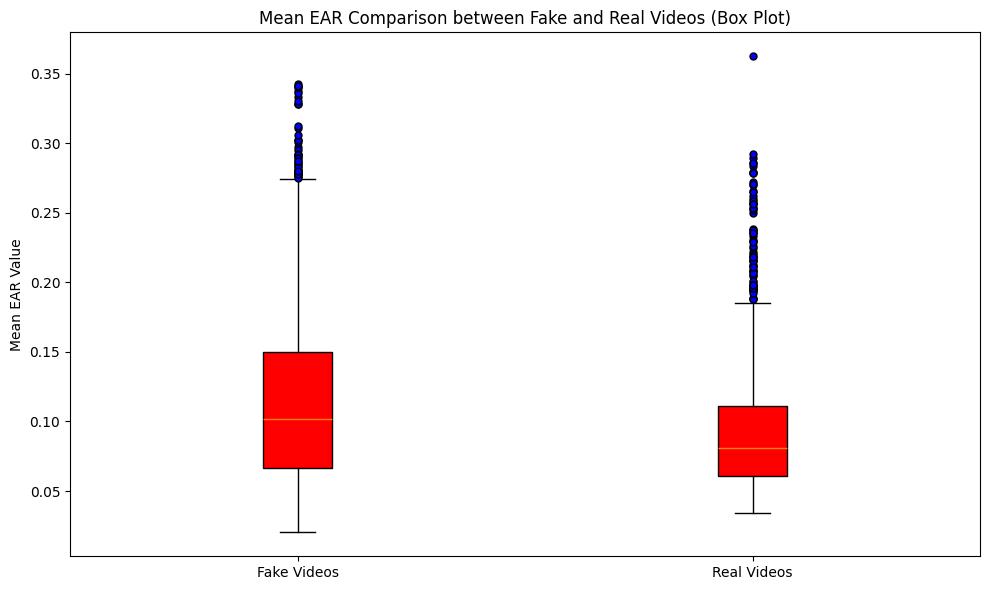

In [8]:
# Extract just the EAR feature (first feature in each frame)
ear_data = X_dataset[:, :, 0]
mean_ear = np.mean(ear_data, axis=1) 

# Split the data into fake and real videos based on the labels
mean_fake_ear = mean_ear[Y_dataset == 0]  # Mean EAR for fake videos
mean_real_ear = mean_ear[Y_dataset == 1]  # Mean EAR for real videos

# Create a box plot for the mean EAR values
plt.figure(figsize=(10, 6))

# Plot the data: each box corresponds to either fake or real videos
plt.boxplot([mean_fake_ear, mean_real_ear], 
            labels=['Fake Videos', 'Real Videos'], 
            patch_artist=True, 
            boxprops=dict(facecolor='red', color='black'),  # Red for fake
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='blue', marker='o', markersize=5))  # Blue for outliers

# Add title and labels
plt.title('Mean EAR Comparison between Fake and Real Videos (Box Plot)')
plt.ylabel('Mean EAR Value')
plt.tight_layout()
plt.show()

In [103]:
# Flatten the data (3748, 1814, 3) -> (3748, 1814 * 3)
X_flat = X_dataset.reshape(X_dataset.shape[0], -1)

scalar = StandardScaler()
X_flat = scalar.fit_transform(X_flat)

X_train, X_test, y_train, y_test = train_test_split(X_flat, Y_dataset, test_size=0.2, random_state=4)

In [104]:
# Reshape target labels to 2D array (required by ReservoirPy Ridge)
y_train = y_train.reshape(-1, 1)  # Shape (n_samples, 1)
y_test =  y_test.reshape(-1, 1)    # Shape (n_samples, 1)

In [113]:
data = Input(input_dim=X_train.shape[1])
reservoir = Reservoir(100, lr=0.4, sr=1.1)
ridge = Ridge(output_dim=y_train.shape[1], ridge=1e-3)

esn = data >> reservoir >> ridge

In [114]:
esn.fit(X_train, y_train)

Running Model-35: 2998it [00:00, 7147.83it/s]<?, ?it/s]
Running Model-35: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

Fitting node Ridge-21...


'Model-35': Model('Input-14', 'Reservoir-21', 'Ridge-21')

In [115]:
# Make predictions & binarize it
predictions = esn.run(X_test)
predicted_labels = (predictions.flatten() > 0.5).astype(int)

Running Model-35: 750it [00:00, 5239.00it/s]           


In [116]:
# Evaluate the model
accuracy = np.mean(predicted_labels == y_test.flatten())
print(f"Model accuracy on test set: {accuracy:.4f}")

Model accuracy on test set: 0.6680


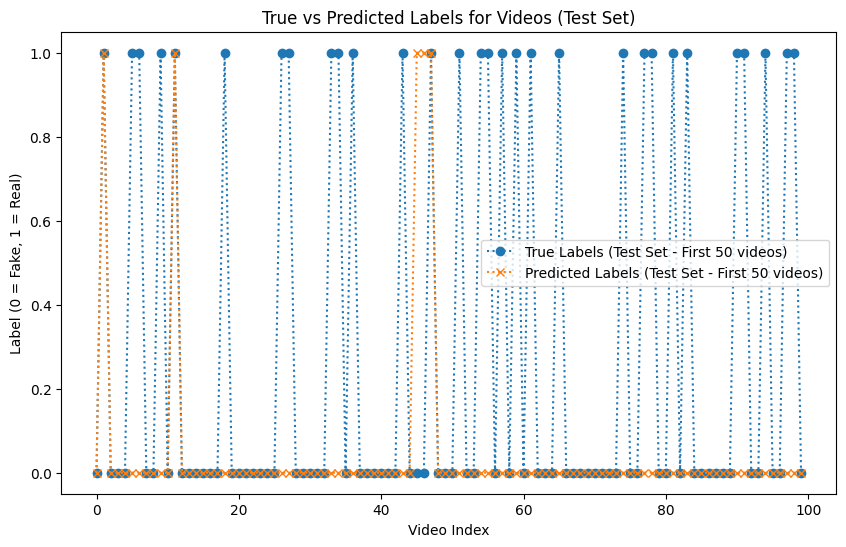

In [123]:
# Plot true vs predicted labels for a subset of the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten()[75:175], label='True Labels (Test Set - First 50 videos)', linestyle=':', marker='o')
plt.plot(predicted_labels[75:175], label='Predicted Labels (Test Set - First 50 videos)', linestyle=':', marker='x')
plt.xlabel('Video Index')
plt.ylabel('Label (0 = Fake, 1 = Real)')
plt.legend()
plt.title('True vs Predicted Labels for Videos (Test Set)')
plt.show()